In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random
from collections import Counter
import matplotlib.pyplot as plt
from openai import OpenAI
from tqdm import tqdm

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
import sys
from pathlib import Path
import os
import pandas as pd

project_root = os.getenv('PROJECT_ROOT')
sys.path.append(str(project_root))
print(project_root)
print(os.getcwd())

/Users/ivang/PycharmProjects/pythonProject/
/Users/ivang/PycharmProjects/pythonProject/notebooks


In [6]:
import json

with open(f"./human_evaluation_topics_all.json", "r") as f:
    human_evaluation_topics_all = json.load(f)

In [7]:
example = human_evaluation_topics_all[0]['sequence']

In [8]:
true_tags = human_evaluation_topics_all[0]['labels'] + human_evaluation_topics_all[0]['overarching_labels'] + human_evaluation_topics_all[0]['keywords_labels']
print(true_tags)
lowest_confidence_tag = human_evaluation_topics_all[0]['lowest_confidence_label']
print(lowest_confidence_tag)

['Low Birth Weight', 'Pregnancy', 'Risk Factors', 'Medical', 'Medical Data', 'Birth Weight', 'Medicine', 'Health', 'Medical Research', 'Obstetrical Data', 'Logistic Regression']
Upselling


In [9]:
tags = true_tags + [lowest_confidence_tag]
# randomize position of all tags
random.shuffle(tags)
tags

['Upselling',
 'Medicine',
 'Low Birth Weight',
 'Logistic Regression',
 'Medical',
 'Medical Data',
 'Pregnancy',
 'Medical Research',
 'Risk Factors',
 'Birth Weight',
 'Obstetrical Data',
 'Health']

In [10]:
# example = """League of Legends is a multiplayer online battle arena where two teams, blue and red, face off. There are three lanes, a jungle, and five roles. The goal is to take down the enemy Nexus to win the game.

# This dataset contains statistics of ranked games from a Platinum Elo. Each game is unique and can be identified by its gameId, which can be used to fetch more attributes from the Riot API. Each game has features from different time frames, from ten minutes to the end of the game. For example, game one at ten minutes, game one at twelve minutes, game one at fourteen minutes, and so on. In total, there are over two hundred forty thousand game frames. There are fifty-five features collected for the Blue team, including kills, deaths, gold, experience, and level. It is up to the user to do some feature engineering to get more insights."""

In [11]:
# tags = ["Ranked Matches", "Games", "League of Legends", "Game Data Analysis", "Computer Games", "Chess", "Gaming", "Esports"]

In [12]:
def construct_stage_1(document: str, tags: list):
    return f"""Intruder Detection
Please read the following document carefully:
"{document}"

Now, examine the list of tags below. One of these tags is an 'intruder' that doesn't belong. Please identify this intruder tag:
{', '.join(tags)}
---
Give your answer in JSON format {{"intruder": "..."}}
"""
    
stage_1 = construct_stage_1(example, tags)
print(stage_1)

Intruder Detection
Please read the following document carefully:
"Name: Low Birth Weight Dataset
Tags: OpenML-Reg

This dataset focuses on identifying risk factors associated with giving birth to low birth weight babies (weighing less than grams). Data were collected on women, of which had low birth weight babies and had normal birth weight babies. Four key variables examined were age, weight of the subject at her last menstrual period, race, and the number of physician visits during the first trimester of pregnancy.

The data were collected at Baystate Medical Center in Springfield, Massachusetts, during. This dataset contains the complete data. Related paired and matched datasets are also available.

The dataset includes variables such as identification code, low birth weight indicator, mother's age, weight at last menstrual period, race, smoking status during pregnancy, history of premature labor, history of hypertension, presence of uterine irritability, number of physician visits 

In [13]:
def construct_stage_2(document: str, true_tags: list):
    return f"""Tag Quality Assessment
Now that you've identified the intruder, here are the predicted tags for this document:
{', '.join(true_tags)}
And here is the document again:
"{document}"
Please rate each tag on its relevance using the 1-5 scales.

Relevance measures how well each tag represents the main themes of the document.

1 - Not relevant at all 2 - Slightly relevant 3 - Moderately relevant 4 - Very relevant 5 - Extremely relevant
---
Please rate each tag on its generality using the 1-5 scales.

Generality measures how general or specific the tag is to this particular document.

1 - Not general at all, specific to this document 2 - Slightly general 3 - Moderately general 4 - Very general 5 - Highly general, could apply to many documents Not Applicable
---
Please rate the coverage using the 1-5 scales.

Coverage measures how well the set of tags covers the range of themes within the document.

1 - Poor coverage, misses major themes, 2 - Limited coverage, 3 - Moderate coverage, 4 - Good coverage, 5 - Excellent coverage, captures all major themes
---
If you selected any rating other than 5: Excellent coverage, please suggest additional tags that would improve the coverage of the document's themes.
---
Give your answer in JSON format {{"relevance": {{"keyword": relevance_score}}, "generality": {{"keyword": generality_score}}, "coverage": coverage_score, "additional_tags": [...]}}, where "keyword" is a string corresponding to the specific keyword, and score is the score you'd give (number)."""

stage_2 = construct_stage_2(example, true_tags)
print(stage_2)

Tag Quality Assessment
Now that you've identified the intruder, here are the predicted tags for this document:
Low Birth Weight, Pregnancy, Risk Factors, Medical, Medical Data, Birth Weight, Medicine, Health, Medical Research, Obstetrical Data, Logistic Regression
And here is the document again:
"Name: Low Birth Weight Dataset
Tags: OpenML-Reg

This dataset focuses on identifying risk factors associated with giving birth to low birth weight babies (weighing less than grams). Data were collected on women, of which had low birth weight babies and had normal birth weight babies. Four key variables examined were age, weight of the subject at her last menstrual period, race, and the number of physician visits during the first trimester of pregnancy.

The data were collected at Baystate Medical Center in Springfield, Massachusetts, during. This dataset contains the complete data. Related paired and matched datasets are also available.

The dataset includes variables such as identification co

In [14]:
def append_to_json(file_path, new_data):
    """Append new data to a JSON array stored in a file."""
    if os.path.exists(file_path):
        with open(file_path, 'r+') as file:
            # Load existing data
            try:
                data = json.load(file)
            except json.JSONDecodeError:
                data = []
            # Append new data
            data.append(new_data)
            # Move the file pointer to the beginning
            file.seek(0)
            # Write the updated data
            json.dump(data, file, indent=2)
            # Truncate the file to the current size
            file.truncate()
    else:
        with open(file_path, 'w') as file:
            # Write new data in a list
            json.dump([new_data], file, indent=2)

In [15]:
# from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type 

# client = OpenAI()

# output_file = 'gpt_evaluation_results.json'

# @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10))
# def make_openai_request(messages, model="gpt-4o-mini"):
#     return client.chat.completions.create(
#         model=model,
#         response_format={"type": "json_object"},
#         messages=messages
#     )

# def process_entry(entry):
#     document = entry['sequence'].split("Keywords:")[0]
#     true_tags = entry['labels'] + entry['overarching_labels'] + entry['keywords_labels']
#     lowest_confidence_tag = entry['lowest_confidence_label']
#     tags = true_tags + [lowest_confidence_tag]
#     random.shuffle(tags)
    
#     stage_1 = construct_stage_1(document, tags)
#     stage_2 = construct_stage_2(document, true_tags)
    
#     messages = [
#         {"role": "system", "content": "You are a helpful assistant designed to output JSON."},
#         {"role": "user", "content": stage_1}
#     ]
    
#     response_1 = make_openai_request(messages)
    
#     result_1 = json.loads(response_1.choices[0].message.content)
    
#     messages.append({"role": "assistant", "content": response_1.choices[0].message.content})
#     messages.append({"role": "user", "content": stage_2})
    
#     response_2 = make_openai_request(messages)
    
#     result_2 = json.loads(response_2.choices[0].message.content)
    
#     return {
#         "document": document,
#         "true_tags": true_tags,
#         "lowest_confidence_tag": lowest_confidence_tag,
#         "stage_1_result": result_1,
#         "stage_2_result": result_2
#     }

# for entry in tqdm(not_found_entries, desc="Processing entries"):
#     try:
#         result_data = process_entry(entry)
#         append_to_json(output_file, result_data)
#     except Exception as e:
#         print(f"Error processing entry: {e}")
#         continue

# print(f"Results saved to {output_file}")

In [16]:
not_found_entries = []
with open("gpt_evaluation_results.json", "r") as f:
    gpt_evaluation_results = json.load(f)
    for entry in human_evaluation_topics_all:
        found_entry = False
        for entry2 in gpt_evaluation_results:
            # if entry2['document'].contains(entry['sequence']):
            # if contains
            if entry2['document'] in entry['sequence']:
                found_entry = True
                break
        if not found_entry:
            not_found_entries.append(entry)

len(not_found_entries)
        

0

# Results

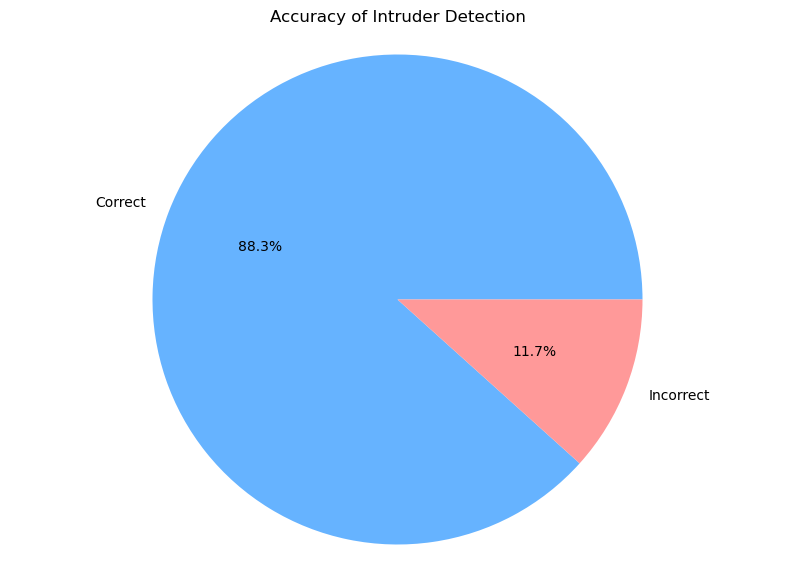

In [17]:
with open('gpt_evaluation_results.json', 'r') as f:
    data = json.load(f)

correct_detections = sum(1 for entry in data if entry['stage_1_result']['intruder'] == entry['lowest_confidence_tag'])
total_entries = len(data)
incorrect_detections = total_entries - correct_detections

plt.figure(figsize=(10, 7))
plt.pie([correct_detections, incorrect_detections], 
        labels=['Correct', 'Incorrect'], 
        autopct='%1.1f%%',
        colors=['#66b3ff', '#ff9999'])
plt.title('Accuracy of Intruder Detection')
plt.axis('equal')
plt.show()

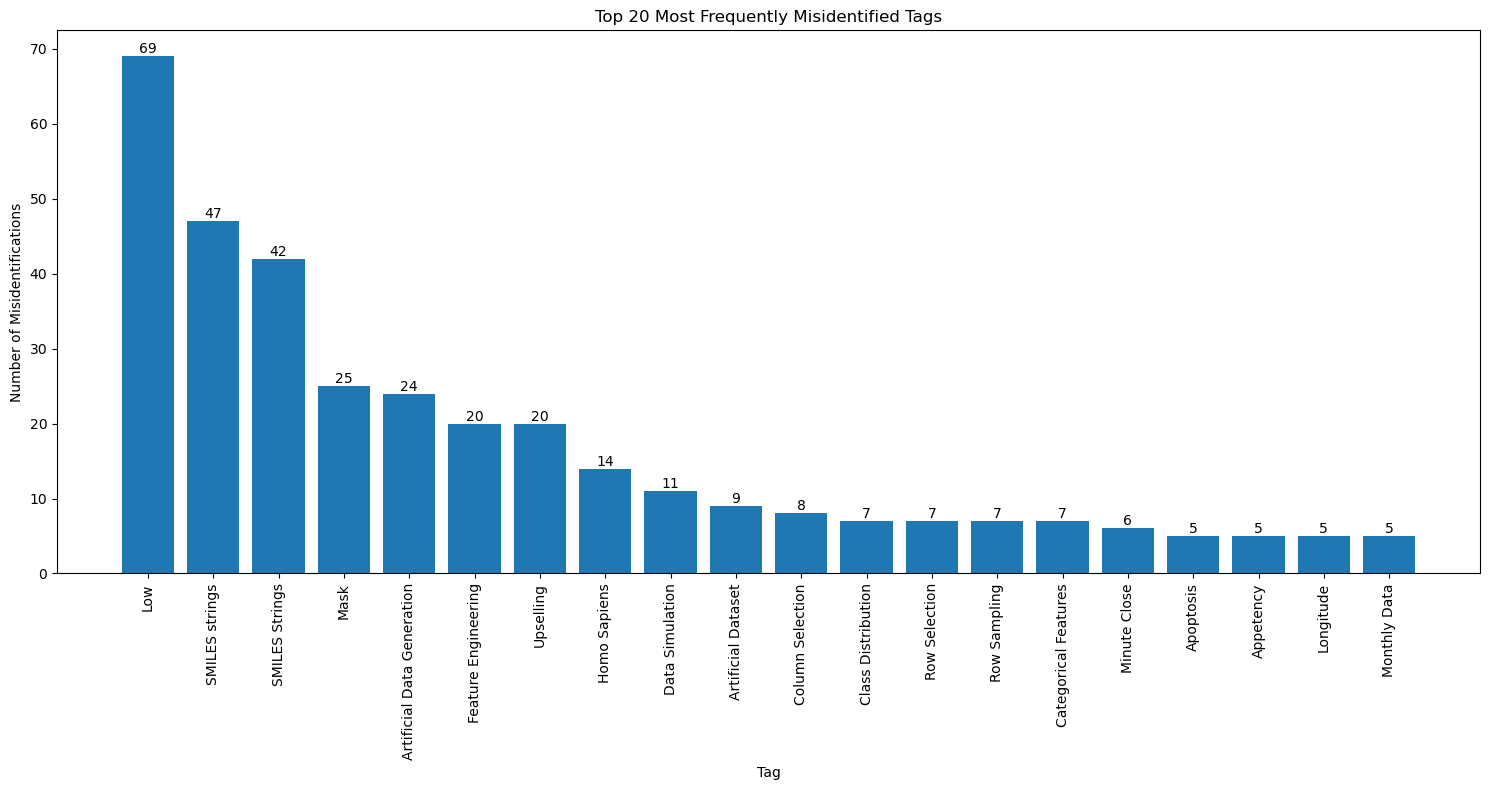


Top 20 most frequently misidentified tags:
Low: 69
SMILES strings: 47
SMILES Strings: 42
Mask: 25
Artificial Data Generation: 24
Feature Engineering: 20
Upselling: 20
Homo Sapiens: 14
Data Simulation: 11
Artificial Dataset: 9
Column Selection: 8
Class Distribution: 7
Row Selection: 7
Row Sampling: 7
Categorical Features: 7
Minute Close: 6
Apoptosis: 5
Appetency: 5
Longitude: 5
Monthly Data: 5


In [27]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the data
with open('gpt_evaluation_results.json', 'r') as f:
    data = json.load(f)

# Initialize a dictionary to count misidentifications
misidentifications = defaultdict(int)

# Count misidentifications
for entry in data:
    predicted_intruder = entry['lowest_confidence_tag']
    actual_intruder = entry['stage_1_result']['intruder']
    
    if predicted_intruder != actual_intruder:
        misidentifications[predicted_intruder] += 1

# Sort tags by number of misidentifications
sorted_misidentifications = sorted(misidentifications.items(), key=lambda x: x[1], reverse=True)

# Select top N tags
N = 20
top_n_tags = sorted_misidentifications[:N]

# Prepare data for plotting
tags, counts = zip(*top_n_tags)

# Create the bar chart
plt.figure(figsize=(15, 8))
plt.bar(range(N), counts)
plt.title(f'Top {N} Most Frequently Misidentified Tags')
plt.xlabel('Tag')
plt.ylabel('Number of Misidentifications')
plt.xticks(range(N), tags, rotation=90)

# Add value labels on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print the top N misidentified tags and their counts
print(f"\nTop {N} most frequently misidentified tags:")
for tag, count in top_n_tags:
    print(f"{tag}: {count}")

In [31]:
import json
from collections import defaultdict

# Load the data
with open('gpt_evaluation_results.json', 'r') as f:
    data = json.load(f)

# Initialize dictionaries to store counts
total_counts = defaultdict(int)
correct_counts = defaultdict(int)

# Process the data
for entry in data:
    num_true_tags = len(entry['true_tags'])
    total_counts[num_true_tags] += 1
    
    if entry['lowest_confidence_tag'] == entry['stage_1_result']['intruder']:
        correct_counts[num_true_tags] += 1

# Calculate percentages
percentages = {k: (correct_counts[k] / total_counts[k]) * 100 if total_counts[k] > 0 else 0 
               for k in total_counts.keys()}

# Print statistics
print("Number of tags | Occurrences | Percentage of correct identifications")
print("-" * 60)
for num_tags in sorted(total_counts.keys()):
    occurrences = total_counts[num_tags]
    percentage = percentages[num_tags]
    print(f"{num_tags:14d} | {occurrences:11d} | {percentage:6.1f}%")

# Calculate correlation
x = list(percentages.keys())
y = list(percentages.values())
correlation = np.corrcoef(x, y)[0, 1]

print("\nCorrelation between number of true tags and percentage of correct identifications:")
print(f"r = {correlation:.3f}")

Number of tags | Occurrences | Percentage of correct identifications
------------------------------------------------------------
             0 |          23 |  100.0%
             1 |          67 |   97.0%
             2 |         182 |   96.2%
             3 |         278 |   92.1%
             4 |         451 |   91.8%
             5 |         492 |   94.5%
             6 |         511 |   91.2%
             7 |         522 |   90.6%
             8 |         502 |   86.3%
             9 |         412 |   86.4%
            10 |         360 |   84.4%
            11 |         255 |   86.7%
            12 |         206 |   86.4%
            13 |         172 |   85.5%
            14 |         146 |   84.9%
            15 |         131 |   87.8%
            16 |          93 |   88.2%
            17 |          61 |   85.2%
            18 |          45 |   80.0%
            19 |          41 |   82.9%
            20 |          21 |   81.0%
            21 |          29 |   75.9%
            

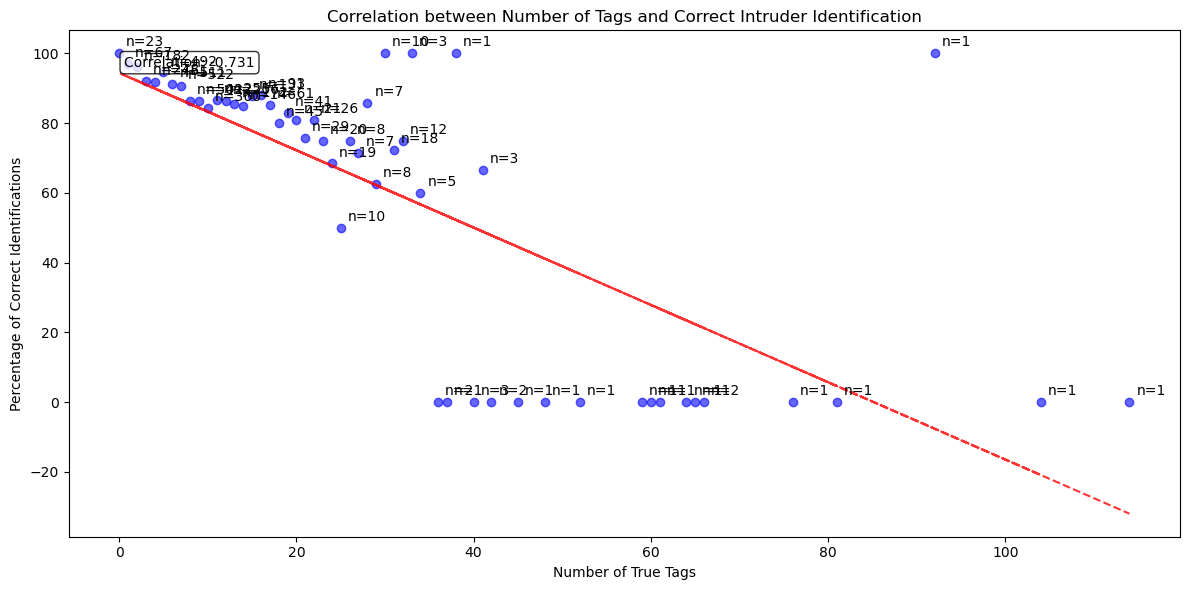

In [32]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the data
with open('gpt_evaluation_results.json', 'r') as f:
    data = json.load(f)

# Initialize dictionaries to store counts
total_counts = defaultdict(int)
correct_counts = defaultdict(int)

# Process the data
for entry in data:
    num_true_tags = len(entry['true_tags'])
    total_counts[num_true_tags] += 1
    
    if entry['lowest_confidence_tag'] == entry['stage_1_result']['intruder']:
        correct_counts[num_true_tags] += 1

# Calculate percentages
percentages = {k: (correct_counts[k] / total_counts[k]) * 100 if total_counts[k] > 0 else 0 
               for k in total_counts.keys()}

# Prepare data for plotting
x = list(percentages.keys())
y = list(percentages.values())

# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(x, y, color='blue', alpha=0.6)

# Add labels and title
plt.xlabel('Number of True Tags')
plt.ylabel('Percentage of Correct Identifications')
plt.title('Correlation between Number of Tags and Correct Intruder Identification')

# Add a trend line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", alpha=0.8)

# Add text box with correlation coefficient
correlation = np.corrcoef(x, y)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add data labels
for i, txt in enumerate(total_counts.values()):
    plt.annotate(f"n={txt}", (x[i], y[i]), xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

Correlation between relevance and generality: 0.292
P-value: 0.000


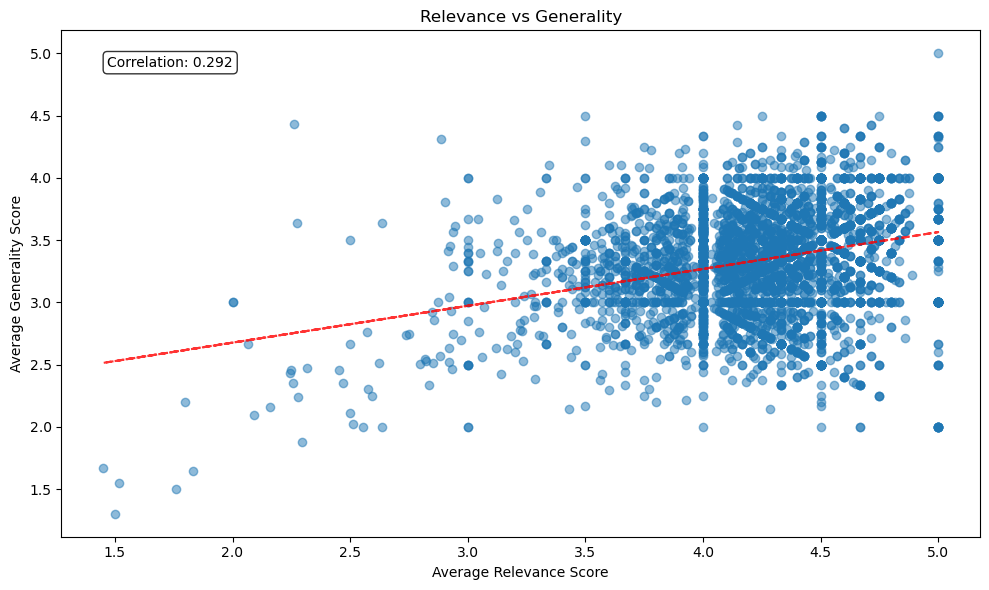

In [33]:
import json
import numpy as np
from scipy import stats

# Load the data
with open('gpt_evaluation_results.json', 'r') as f:
    data = json.load(f)

# Lists to store relevance and generality scores
relevance_scores = []
generality_scores = []

# Extract relevance and generality scores
for entry in data:
    if 'stage_2_result' in entry and 'relevance' in entry['stage_2_result'] and 'generality' in entry['stage_2_result']:
        relevance = entry['stage_2_result']['relevance']
        generality = entry['stage_2_result']['generality']
        
        # Calculate average scores for each entry
        avg_relevance = sum(relevance.values()) / len(relevance)
        avg_generality = sum(generality.values()) / len(generality)
        
        relevance_scores.append(avg_relevance)
        generality_scores.append(avg_generality)

# Calculate correlation
correlation, p_value = stats.pearsonr(relevance_scores, generality_scores)

print(f"Correlation between relevance and generality: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

# Create a scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(relevance_scores, generality_scores, alpha=0.5)
plt.xlabel('Average Relevance Score')
plt.ylabel('Average Generality Score')
plt.title('Relevance vs Generality')

# Add trend line
z = np.polyfit(relevance_scores, generality_scores, 1)
p = np.poly1d(z)
plt.plot(relevance_scores, p(relevance_scores), "r--", alpha=0.8)

# Add correlation coefficient to plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [26]:
import json
from collections import defaultdict
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Load the data
data = load_json('gpt_evaluation_results.json')

# Initialize data structures
tag_relevance = defaultdict(list)
tag_generality = defaultdict(list)
all_relevance_scores = []
all_generality_scores = []

# Process the data
for entry in data:
    if 'stage_2_result' in entry:
        if 'relevance' in entry['stage_2_result']:
            relevance_scores = entry['stage_2_result']['relevance']
            for tag, score in relevance_scores.items():
                tag_relevance[tag].append(score)
                all_relevance_scores.append(score)
        if 'generality' in entry['stage_2_result']:
            generality_scores = entry['stage_2_result']['generality']
            for tag, score in generality_scores.items():
                tag_generality[tag].append(score)
                all_generality_scores.append(score)

# Calculate average scores per tag
avg_relevance_per_tag = {tag: sum(scores) / len(scores) for tag, scores in tag_relevance.items()}
avg_generality_per_tag = {tag: sum(scores) / len(scores) for tag, scores in tag_generality.items()}

# Calculate means and standard deviations
relevance_mean = np.mean(all_relevance_scores)
generality_mean = np.mean(all_generality_scores)
relevance_std = np.std(all_relevance_scores)
generality_std = np.std(all_generality_scores)

# Sort tags by average scores
sorted_relevance_tags = sorted(avg_relevance_per_tag.items(), key=lambda x: x[1], reverse=True)
sorted_generality_tags = sorted(avg_generality_per_tag.items(), key=lambda x: x[1], reverse=True)

# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    "Average Relevance Score per Tag", "Average Generality Score per Tag",
    "Overall Distribution of Relevance Scores", "Overall Distribution of Generality Scores"
))

# Add bar charts for average scores
fig.add_trace(go.Bar(x=[tag for tag, _ in sorted_relevance_tags], y=[score for _, score in sorted_relevance_tags], name="Avg Relevance"), row=1, col=1)
fig.add_trace(go.Bar(x=[tag for tag, _ in sorted_generality_tags], y=[score for _, score in sorted_generality_tags], name="Avg Generality"), row=1, col=2)

# Add histograms for overall distribution of scores
fig.add_trace(go.Histogram(x=all_relevance_scores, nbinsx=20, name="Relevance Distribution"), row=2, col=1)
fig.add_trace(go.Histogram(x=all_generality_scores, nbinsx=20, name="Generality Distribution"), row=2, col=2)

# Add vertical lines for mean and standard deviations on relevance histogram
fig.add_vline(x=relevance_mean, line_dash="solid", line_color="red", row=2, col=1)
fig.add_vline(x=relevance_mean - relevance_std, line_dash="dash", line_color="green", row=2, col=1)
fig.add_vline(x=relevance_mean + relevance_std, line_dash="dash", line_color="green", row=2, col=1)

# Add vertical lines for mean and standard deviations on generality histogram
fig.add_vline(x=generality_mean, line_dash="solid", line_color="red", row=2, col=2)
fig.add_vline(x=generality_mean - generality_std, line_dash="dash", line_color="green", row=2, col=2)
fig.add_vline(x=generality_mean + generality_std, line_dash="dash", line_color="green", row=2, col=2)

# Update layout
fig.update_layout(height=1200, title_text="Tag Relevance and Generality Analysis", showlegend=False)
fig.update_xaxes(title_text="Tag", row=1, col=1)
fig.update_xaxes(title_text="Tag", row=1, col=2)
fig.update_yaxes(title_text="Average Score", range=[0, 5], row=1, col=1)
fig.update_yaxes(title_text="Average Score", range=[0, 5], row=1, col=2)
fig.update_xaxes(title_text="Score", row=2, col=1)
fig.update_xaxes(title_text="Score", row=2, col=2)
fig.update_yaxes(title_text="Count", row=2, col=1)
fig.update_yaxes(title_text="Count", row=2, col=2)

# Add annotations for overall averages and standard deviations
fig.add_annotation(text=f"Mean: {relevance_mean:.2f}<br>Std Dev: {relevance_std:.2f}", xref="x3", yref="paper", x=0.5, y=1.05, showarrow=False)
fig.add_annotation(text=f"Mean: {generality_mean:.2f}<br>Std Dev: {generality_std:.2f}", xref="x4", yref="paper", x=0.5, y=1.05, showarrow=False)

# Add legend for the vertical lines
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='red', dash='solid'), name='Mean'), row=2, col=1)
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='green', dash='dash'), name='±1 Std Dev'), row=2, col=1)

# Show the plot
fig.show()

print(f"\nOverall Average Relevance Score: {relevance_mean:.2f}")
print(f"Overall Average Generality Score: {generality_mean:.2f}")
print(f"Relevance Standard Deviation: {relevance_std:.2f}")
print(f"Generality Standard Deviation: {generality_std:.2f}")


Overall Average Relevance Score: 4.11
Overall Average Generality Score: 3.29
Relevance Standard Deviation: 0.98
Generality Standard Deviation: 0.87


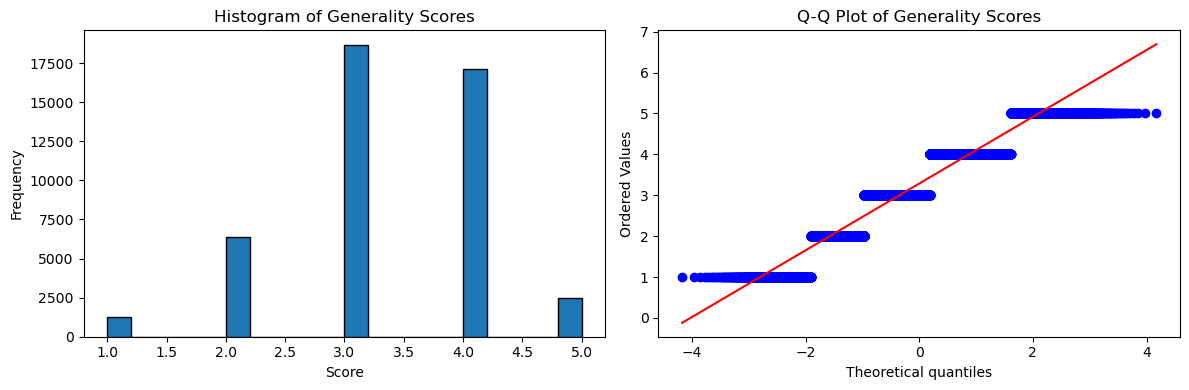

In [21]:
from scipy import stats

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Load the data
data = load_json('gpt_evaluation_results.json')

# Extract generality scores
all_generality_scores = []
for entry in data:
    if 'stage_2_result' in entry and 'generality' in entry['stage_2_result']:
        all_generality_scores.extend(entry['stage_2_result']['generality'].values())

# Convert to numpy array
all_generality_scores = np.array(all_generality_scores)

# 1. Visual Inspection
plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(121)
plt.hist(all_generality_scores, bins=20, edgecolor='black')
plt.title('Histogram of Generality Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(122)
stats.probplot(all_generality_scores, dist="norm", plot=plt)
plt.title('Q-Q Plot of Generality Scores')

plt.tight_layout()
plt.show()

In [22]:
# 2. Statistical Tests
# Shapiro-Wilk Test
shapiro_test = stats.shapiro(all_generality_scores)
print(f"Shapiro-Wilk Test - Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}")

# Anderson-Darling Test
anderson_test = stats.anderson(all_generality_scores, dist='norm')
print(f"Anderson-Darling Test - Statistic: {anderson_test.statistic:.4f}")
for i in range(len(anderson_test.critical_values)):
    sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
    print(f'  {sl}%: {cv:.3f}')

Shapiro-Wilk Test - Statistic: 0.8786, p-value: 0.0000
Anderson-Darling Test - Statistic: 2641.2348
  15.0%: 0.576
  10.0%: 0.656
  5.0%: 0.787
  2.5%: 0.918
  1.0%: 1.092


/var/folders/cl/69z7wmcn5xx7cb7wc_xvd8fw0000gn/T/ipykernel_7258/3709420088.py:3: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45916.



In [23]:
# 3. Skewness and Kurtosis
skewness = stats.skew(all_generality_scores)
kurtosis = stats.kurtosis(all_generality_scores)
print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

# Calculate mean and standard deviation
mean = np.mean(all_generality_scores)
std_dev = np.std(all_generality_scores)
print(f"Mean: {mean:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")

# 4. Check for discrete vs continuous distribution
unique_values = np.unique(all_generality_scores)
print(f"Number of unique values: {len(unique_values)}")
print(f"Unique values: {unique_values}")

Skewness: -0.3544
Kurtosis: -0.0169
Mean: 3.2869
Standard Deviation: 0.8705
Number of unique values: 5
Unique values: [1 2 3 4 5]
